# Преобразование PWM для autosome-софта

In [1]:
tf_name_pattern = 'TF Name'
motif_name_pattern = 'Motif'
matrix_pattern = 'Pos'
filename = ''
pfm = ''
with open("../data/motifs/CisBP/PWM.txt") as data:
    for line in data:
        if line.startswith(tf_name_pattern):
            filename = line[line.index(tf_name_pattern) + len(tf_name_pattern) + 1 : -1]
            continue
        if line.startswith(motif_name_pattern):
            filename = filename + '_' + line[line.index(motif_name_pattern) + len(motif_name_pattern) + 1 :-1]            
            print filename
            continue
        
        if line.startswith(matrix_pattern):
            line = data.next()
            with open('../data/motifs/pwm/' + filename + '.pfm', 'w') as out:
                while (line != '\n'):
                    line = line.replace('\n', '')
                    freqs = line.split('\t')
                    out_line = ''
                    for freq in freqs[1 :]:
                        out_line = out_line + freq + '\t'
                    out_line = out_line + '\n'
                    out.write(out_line)
                    line = data.next()

DDB_G0275333_M0101_1.02
bzpD_M0284_1.02
bzpF_M0285_1.02
bzpH_M0283_1.02
bzpJ_M0282_1.02
bzpO_M0287_1.02
bzpQ_M0286_1.02
bzpS_M0288_1.02
dimB_M0289_1.02
E2F_M0666_1.02
gtaC_M0776_1.02
gtaE_M0773_1.02
gtaG_M0774_1.02
gtaH_M0777_1.02
gtaI_M0779_1.02
gtaL_M0780_1.02
gtaN_M0781_1.02
gtaT_M0778_1.02
stkA_M0775_1.02
hbx10_M0878_1.02
hbx2_M0875_1.02
hbx4_M0872_1.02
hbx5-1_M0873_1.02
hbx5-2_M0874_1.02
hbx7_M0876_1.02
hbx9_M0877_1.02
srfA_M1297_1.02
mybA_M1354_1.02
mybAA_M1347_1.02
mybE_M1349_1.02
mybG_M1351_1.02
mybI_M1352_1.02
mybQ_M1353_1.02
mybV_M1348_1.02
mybZ_M1350_1.02
gbfA_M1673_1.02
gbfA_M2427_1.02
DDB_G0270590_M1714_1.02


# Ищем совпадения между мотивами и петлями

In [2]:
import pandas as pd
import glob
import numpy as np

In [4]:
loops_info = pd.read_excel('../../data/dicty_loop_positions_Chr1_Chr6.xlsx')

In [5]:
loops_info.head()

,Chr,ID,"Genomic bin, Left base","Genomic bin, Right base",Size (Kb),"""Extrusion track""","Note for extrusion tracks: 0=n/a, 1=from the left base, 2=from the right base"
0,1,1,107,114,16,0,NaN
1,1,2,114,123,20,1,NaN
2,1,3,176,187,24,2,NaN
3,1,4,187,194,16,0,NaN
4,1,5,194,209,32,2,NaN


In [8]:
chr_with_loops = sorted(loops_info.Chr.unique())
chr_with_loops = ['chr' + str(chr) for chr in chr_with_loops]
chr_with_loops

['chr1', 'chr6']

In [9]:
df = loops_info[['Chr', 'Genomic bin, Left base']]
df['Type'] = 'loop'

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
# Новые данные
loops_info = pd.DataFrame(columns=['Chr', 'Genomic bin, Left base', 'Genomic bin, Right base'])
dr = '../../data/loops/'
for i in range(1, 7):
    filename = dr + 'chr' + str(i) + '.csv'
    with open(filename) as inp:
        lines = inp.readlines()[1: ] # без heading
        lines = [line.strip().split(',') for line in lines]
        for line in lines:
            loops_info = loops_info.append({'Chr': i, 'Genomic bin, Left base': int(float(line[1])), \
                                            'Genomic bin, Right base': int(float(line[0]))}, ignore_index = True)

In [4]:
chr_with_loops = ['chr' + str(i) for i in range(1,7)]
chr_with_loops

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6']

In [5]:
loop_motif_dic = {}
loop_motif_df = pd.DataFrame(columns=['Motif name', 'Frequency', 'Occuriencies around loops', 'Occuriencies in genome'])
acc_dic = {}
window = 2000
for filename in glob.glob('../../data/motifs/tmp/*.bed'):
    with open(filename) as f:
        lines = [line.strip().split() for line in f.readlines()]
        genome_occur = len(lines)
        count_in_loops = 0
        
        lines = filter(lambda line: line[0] in chr_with_loops, lines)
        chroms_occur = len(lines)
        
        acc_dic[filename] = [(line[0] + '_' + str(int(round(int(line[1]) / 2000)))) \
                         for line in lines \
                         if int(round(int(line[1]) / 2000)) in \
                         loops_info[loops_info['Chr'] == int(line[0][3])]['Genomic bin, Left base'].values]
        
        for line in lines:
            chr_name = int(line[0][3])
            motif_name = line[3][: line[3].index(';')]
            for loop in loops_info[loops_info['Chr'] == chr_name].iterrows():
                left_index = loop[1]['Genomic bin, Left base']
                right_index = loop[1]['Genomic bin, Right base']
                motif_index = int(round(int(line[1])/2000))
                
                motif_bp_index = int(line[1])
                left_bp_index = loop[1]['Genomic bin, Left base'] * 2000
                right_bp_index = loop[1]['Genomic bin, Right base'] * 2000
                if ((motif_bp_index >= left_bp_index - window) and (motif_bp_index <= left_bp_index + window))\
                or ((motif_bp_index >= right_bp_index - window) and (motif_bp_index <= right_bp_index + window)):
                    loop_label = 'Chr' + str(chr_name) + '_' + str(int(left_index)) + \
                                '_' + str(int(right_index)) + '_' + str(motif_index)
                    tmp_dic = loop_motif_dic.get(loop_label, {})
                    tmp_dic[motif_name] = tmp_dic.get(motif_name, 0) + 1
                    loop_motif_dic[loop_label] = tmp_dic
                    count_in_loops = count_in_loops + 1
                    
                s = line[0] + '_' + str(int(round(int(line[1]) / 2000)))
                if motif_bp_index < left_bp_index - window:
                    break
                    
    loop_motif_df = loop_motif_df.append({'Motif name': motif_name, \
                                          'Frequency': (count_in_loops * 1.0) / genome_occur, \
                                          'Occuriencies around loops': count_in_loops, \
                                          'Occuriencies in genome': genome_occur}, ignore_index=True)

In [67]:
motif_df = pd.DataFrame(columns=['Chr', 'Motif name', 'Motif pos'])
for filename in glob.glob('../../data/motifs/tmp/*.bed'):
    with open(filename) as f:
        lines = [line.strip().split() for line in f.readlines()]
        lines = filter(lambda line: line[0] in chr_with_loops, lines)
        
        for line in lines:
            chr_name = int(line[0][3])
            motif_name = line[3][: line[3].index(';')]
            motif_bp_index = int(line[1])
            motif_index = int(round(motif_bp_index/2000))    
            
            motif_df = motif_df.append({'Chr': line[0], 'Motif name': motif_name, \
                                        'Motif pos': motif_index}, ignore_index=True)

In [71]:
with open('../../data/motifs/motifs.csv', 'w') as out:
    heading = 'Chr;Motif name;Motif pos\n'
    out.write(heading)
    for _,row in motif_df.iterrows():
        out.write(row[0] + ';' + str(row[1]) + ';' + str(row[2]) + '\n')

In [65]:
chr_with_loops

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6']

In [40]:
detail_loop_df = pd.DataFrame(columns=['Chr', 'Left', 'Right', 'Motif pos', 'Motif name', 'Frequency', 'Occuriencies around loop', 'Occuriencies in genome'])
for (pos, d) in loop_motif_dic.iteritems():
    chrname = pos[ : pos.find('_')]
    p = pos[ pos.find('_')+1 : ]
    left = p[: p.find('_')]
    p = pos[ pos.find('_')+1 : ]
    right = p[: p.find('_')]
    motif = p[p.find('_')+1 : ]
    for (m_name, cnt) in d.iteritems():
        genome_cnt = loop_motif_df[loop_motif_df['Motif name'] == m_name]['Occuriencies in genome'].values[0]
        detail_loop_df = detail_loop_df.append({'Chr': chrname, \
                                                'Left': left, \
                                                'Right': right, \
                                                'Motif pos': motif, \
                                                'Motif name': m_name, \
                                                'Frequency': cnt * 1.0 / genome_cnt, \
                                                'Occuriencies around loop': cnt, \
                                                'Occuriencies in genome': genome_cnt}, ignore_index=True)

# Графики

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

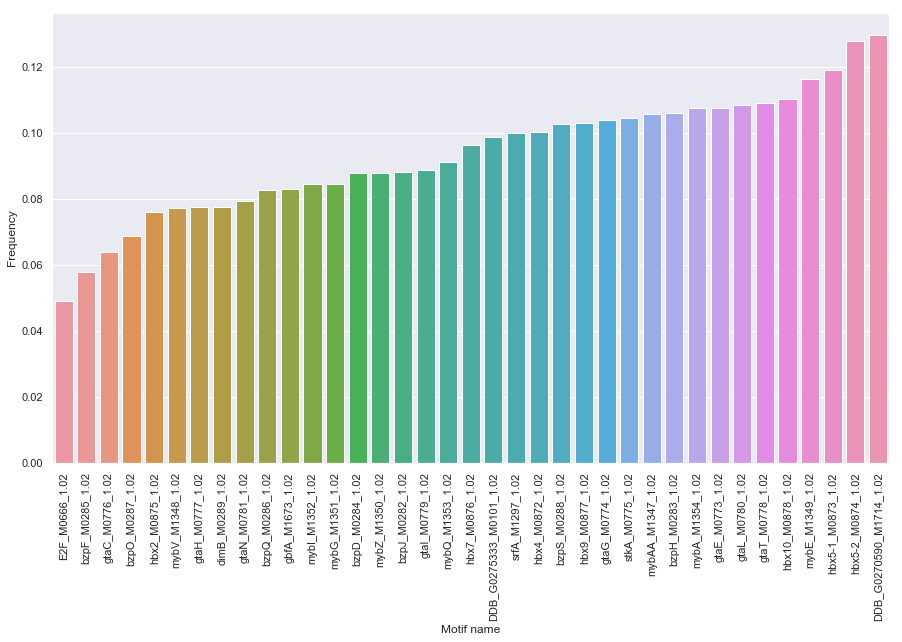

In [58]:
sns.set(rc = {'figure.figsize':(15,8.27)})
ax = sns.barplot(x='Motif name', y ='Frequency', \
                 data=loop_motif_df.sort_values(by='Frequency'))
ax.set_xticklabels(labels = plt.xticks()[1], rotation=90)
plt.show()

In [180]:
loop_motif_df.head()

,Motif name,Frequency,Occuriencies around loops,Occuriencies in genome
0,stkA_M0775_1.02,0.012007,7,583
1,gtaI_M0779_1.02,0.002770,1,361
2,gtaG_M0774_1.02,0.005780,1,173
3,bzpJ_M0282_1.02,0.012859,13,1011
4,bzpO_M0287_1.02,0.024510,5,204


In [138]:
with open('../data/motifs/motifs_around_loops.csv', 'w') as out:
    heading = 'Motif name;Frequency;Occuriencies around loops;Occuriencies in genome\n'
    out.write(heading)
    for row in loop_motif_df.iterrows():
        s = '%s;%.5f;%d;%d\n' % \
        (row[1]['Motif name'], row[1]['Frequency'], row[1]['Occuriencies around loops'], row[1]['Occuriencies in genome'])
        out.write(s)

In [41]:
detail_loop_df.head()

,Chr,Left,Right,Motif name,Frequency,Occuriencies around loop,Occuriencies in genome
0,Chr2,223,242,hbx10_M0878_1.02,0.000320,1,3127
1,Chr6,715,721,mybG_M1351_1.02,0.000131,1,7662
2,Chr6,715,721,hbx5-1_M0873_1.02,0.000093,1,10702
3,Chr6,715,721,E2F_M0666_1.02,0.001256,1,796
4,Chr2,232,241,bzpH_M0283_1.02,0.000363,2,5514


In [53]:
with open('../../data/motifs/detail_motifs_around_loops.csv', 'w') as out:
    heading = 'Chr;Left;Right;Motif name;Frequency;Occuriencies around loop;Occuriencies in genome\n'
    out.write(heading)
    for row in detail_loop_df.iterrows():
        s = '%s;%s;%s;%s;%.5f;%d;%d\n' % \
        (row[1]['Chr'].lower(), row[1]['Left'], row[1]['Right'], row[1]['Motif name'], row[1]['Frequency'], row[1]['Occuriencies around loop'], row[1]['Occuriencies in genome'])
        out.write(s)